# Installations/imports

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
#from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco

Load CSV

In [130]:
df_org = pd.read_csv("stock_price_translated.csv")
df = df_org.copy()

# Data Understanding and EDA

In [131]:
df.head()

,Date,Closing price,Opening price,High price,Low price,Volume,Rate of change %
0,01-08-2024,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,31-07-2024,160.4,158.2,160.7,158.1,173.91M,1.07%
2,30-07-2024,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,29-07-2024,159.7,158.7,160.2,158.4,126.28M,1.14%
4,26-07-2024,157.9,159.3,159.6,157.9,155.08M,-0.13%


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              9202 non-null   object 
 1   Closing price     9202 non-null   float64
 2   Opening price     9202 non-null   float64
 3   High price        9202 non-null   float64
 4   Low price         9202 non-null   float64
 5   Volume            9202 non-null   object 
 6   Rate of change %  9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB


The dataset contains 9202 entries and 7 columns:

Date: Stock data date (string).

Closing price: Closing price of the stock (float).

Opening price: Opening price of the stock (float).

High price: Highest price during the day (float).

Low price: Lowest price during the day (float).

Volume: Trading volume, currently formatted as strings (e.g., "79.15M").

Rate of change %: Daily percentage change in stock price, also formatted as strings (e.g., "-2.56%").

In [133]:
# The summary statistics for numerical columns

df.describe()

,Closing price,Opening price,High price,Low price
count,9202.000000,9202.000000,9202.000000,9202.000000
mean,92.180961,92.256183,93.176451,91.330146
std,50.452228,50.598215,51.049837,50.087405
min,33.000000,33.000000,33.200000,32.200000
25%,52.000000,52.100000,52.800000,51.500000
50%,85.100000,85.100000,86.050000,84.200000
75%,110.800000,110.800000,111.900000,109.275000
max,305.900000,309.800000,311.800000,303.900000


In [134]:
# Check for missing values

missing_values = df.isnull().sum()
missing_values

,0
Date,0
Closing price,0
Opening price,0
High price,0
Low price,0
Volume,0
Rate of change %,0


There are no null(NaN) values in the dataset

it seems Volume column has values in both millions and billions

In [135]:
billion_rows = df[df['Volume'].str.contains('B', na=False)]
print("Rows with volume in billions:\n", billion_rows)

Rows with volume in billions:
             Date  Closing price  Opening price  High price  Low price Volume  \
2627  30-10-2013           51.3           51.6        52.0       50.3  1.03B   
3121  28-10-2011           40.0           39.4        40.2       39.0  1.05B   
3325  29-12-2010           36.7           36.9        37.0       36.5  1.05B   
3765  12-03-2009           34.3           35.9        36.0       33.9  1.06B   
3965  14-05-2008           49.8           49.3        49.8       48.4  1.20B   
4211  14-05-2007           56.6           58.6        59.2       55.3  1.15B   
4456  16-05-2006           55.9           55.8        57.4       55.7  1.18B   
4457  15-05-2006           55.4           53.9        56.1       53.8  1.05B   
9201  12-02-1987          182.4          182.4       182.4      182.4  1.28B   

     Rate of change %  
2627           -0.58%  
3121            3.63%  
3325           -0.81%  
3765           -5.77%  
3965           11.16%  
4211           -6.60%  


Dropping high  values to get a better avrerage representation

In [136]:
# Drop rows where 'Volume' contains 'B'
df = df[~df['Volume'].str.contains('B', na=False)]
df.reset_index(drop=True, inplace=True)

In [137]:
# Adjust the 'Volume' conversion to handle both 'M' (millions) and 'B' (billions)
df['Volume'] = df['Volume'].replace({'M': 'e6'}, regex=True).astype(float)

In [138]:
# Convert 'Rate of change %' by removing '%' and converting to a numeric type
df['Rate of change %'] = df['Rate of change %'].replace({'%': ''}, regex=True).astype(float)

In [139]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [140]:
# Check for summary statistics for numerical columns
summary_statistics = df.describe()
summary_statistics

,Date,Closing price,Opening price,High price,Low price,Volume,Rate of change %
count,9193,9193.000000,9193.000000,9193.000000,9193.000000,9.193000e+03,9193.000000
mean,2005-10-20 23:59:03.609267712,92.210029,92.285174,93.205656,91.359154,1.717435e+08,0.015091
min,1987-02-13 00:00:00,33.000000,33.000000,33.200000,32.200000,9.340000e+06,-14.740000
25%,1996-06-05 00:00:00,52.100000,52.100000,52.800000,51.500000,8.051000e+07,-0.940000
50%,2005-10-05 00:00:00,85.100000,85.100000,86.100000,84.300000,1.539100e+08,0.000000
75%,2015-03-09 00:00:00,110.800000,110.800000,112.000000,109.300000,2.301100e+08,0.900000
max,2024-08-01 00:00:00,305.900000,309.800000,311.800000,303.900000,9.908800e+08,15.000000
std,NaN,50.450296,50.596540,51.048631,50.084942,1.216229e+08,1.863136


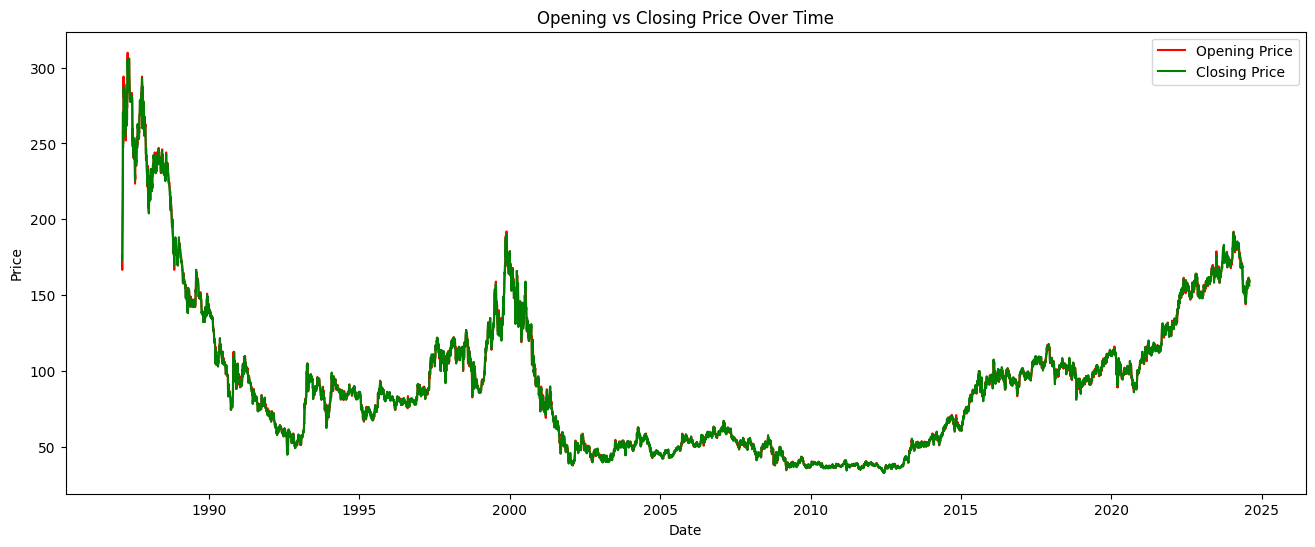

In [141]:
# Plotting Opening and Closing Prices over time
plt.figure(figsize=(16,6))

# Plot Opening Prices
plt.plot(df['Date'], df['Opening price'], label='Opening Price', color='red')

# Plot Closing Prices
plt.plot(df['Date'], df['Closing price'], label='Closing Price', color='green')

# Add labels and title
plt.title('Opening vs Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

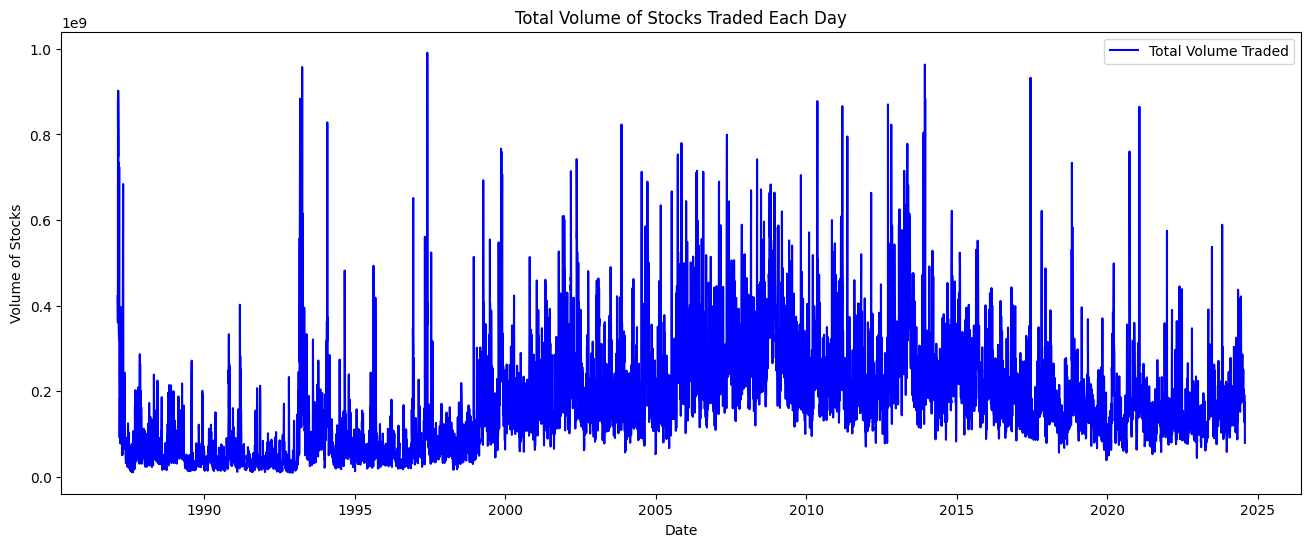

In [142]:
# Plotting Total Volume of Stocks Traded
plt.figure(figsize=(16,6))

plt.plot(df['Date'], df['Volume'], color='blue', label='Total Volume Traded')

# Add labels and title
plt.title('Total Volume of Stocks Traded Each Day')
plt.xlabel('Date')
plt.ylabel('Volume of Stocks')
plt.legend()

# Show the plot
plt.show()

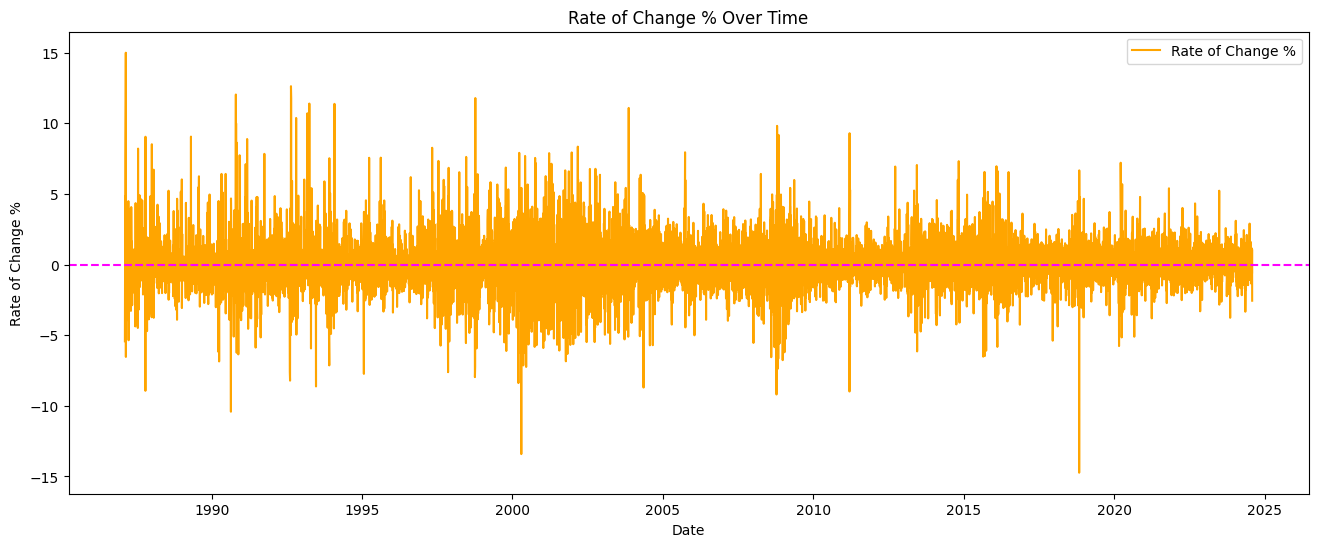

In [143]:
# Plotting the Rate of Change %
plt.figure(figsize=(16,6))

plt.plot(df['Date'], df['Rate of change %'], color='orange', label='Rate of Change %')

# Add labels and title
plt.title('Rate of Change % Over Time')
plt.xlabel('Date')
plt.ylabel('Rate of Change %')
plt.legend()

plt.axhline(y=0, color='magenta', linestyle='--', label='0% Change')

# Show the plot
plt.show()

Removing rows where 'Rate of change %' is greater than 10% as it may creare bias to the average/ moving average values to be taken later.

In [144]:
#  Function to removes rows where 'Rate of change %' is greater than 10%
def remove_high_rate_of_change(df):

    df['Rate of change %'] = df['Rate of change %'].replace({'%': ''}, regex=True).astype(float)
    cleaned_df = df[df['Rate of change %'] <= 10]

    return cleaned_df

In [145]:
df = remove_high_rate_of_change(df)
df.head()

,Date,Closing price,Opening price,High price,Low price,Volume,Rate of change %
0,2024-08-01,156.3,159.3,159.4,156.1,79150000.0,-2.56
1,2024-07-31,160.4,158.2,160.7,158.1,173910000.0,1.07
2,2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63
3,2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14
4,2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13


Analysing Monthly Mean of Closing price

In [146]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)

<ipython-input-147-3e5b1602ade4>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_close = df['Closing price'].resample('M').mean()


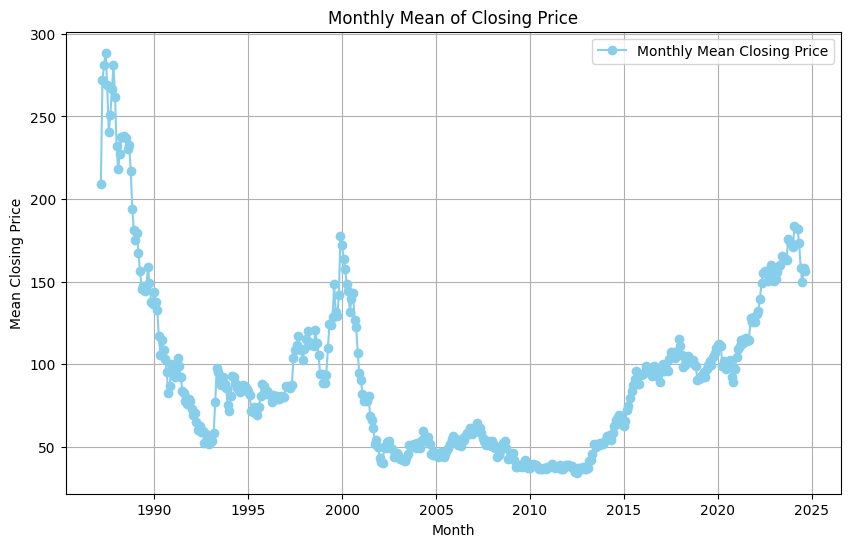

,Closing price
Date,
1987-02-28,209.155556
1987-03-31,272.240909
1987-04-30,280.857143
1987-05-31,288.552632
1987-06-30,268.940909


In [147]:
monthly_mean_close = df['Closing price'].resample('M').mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean_close.index, monthly_mean_close, color='skyblue', marker='o', label='Monthly Mean Closing Price')

# Add labels and title
plt.title('Monthly Mean of Closing Price')
plt.xlabel('Month')
plt.ylabel('Mean Closing Price')
plt.legend()

# Show the plot
plt.grid()
plt.show()

monthly_mean_close.head(5)

Annual

<ipython-input-148-f858a3c736ff>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean_close = df['Closing price'].resample('Y').mean()


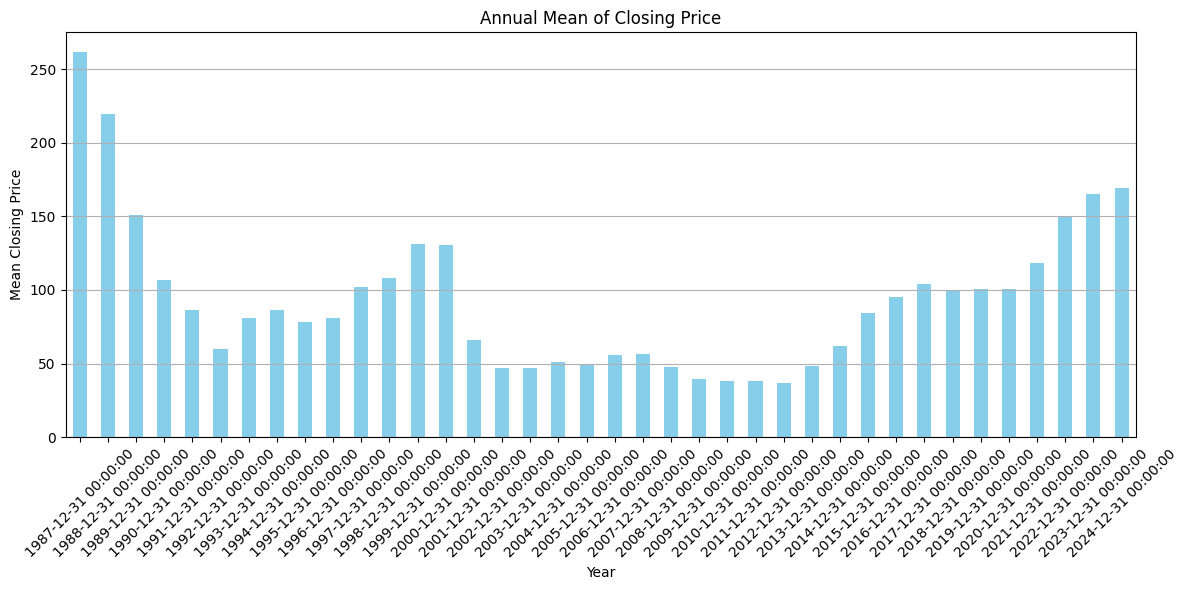

In [148]:
annual_mean_close = df['Closing price'].resample('Y').mean()

# Plotting the Annual Mean Closing Price as a bar graph
plt.figure(figsize=(12, 6))
annual_mean_close.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Annual Mean of Closing Price')
plt.xlabel('Year')
plt.ylabel('Mean Closing Price')
plt.xticks(rotation=45)

# Show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Relationship between Volume and Closing Price

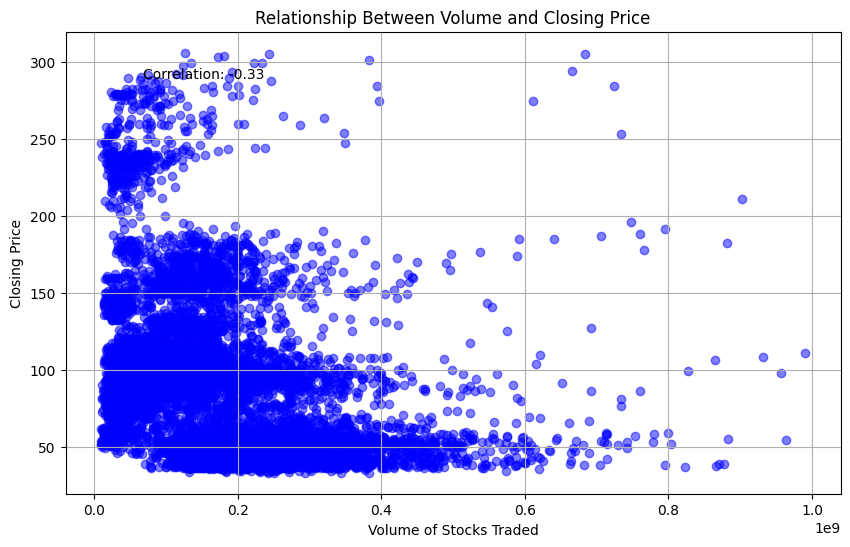

In [149]:
# Scatter plot to show the relationship between Volume and Closing Price
plt.figure(figsize=(10, 6))
plt.scatter(df['Volume'], df['Closing price'], alpha=0.5, color='blue')
plt.title('Relationship Between Volume and Closing Price')
plt.xlabel('Volume of Stocks Traded')
plt.ylabel('Closing Price')
plt.grid()

# Calculate the correlation coefficient
correlation = df['Volume'].corr(df['Closing price'])
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)

# Show the plot
plt.show()

**Moving Averages** (Technical Indicator)

In [150]:
# Moving averages (5-day and 20-day moving averages)

'''
df['MA_5'] = df['Closing price'].rolling(window=5).mean()
df['MA_20'] = df['Closing price'].rolling(window=20).mean()
 '''

"\ndf['MA_5'] = df['Closing price'].rolling(window=5).mean()\ndf['MA_20'] = df['Closing price'].rolling(window=20).mean()\n "

**Volatility Features**

In [151]:
# Volatility features (7-day rolling standard deviation)
'''
df['Volatility_7'] = df['Closing price'].rolling(window=7).std()
'''

"\ndf['Volatility_7'] = df['Closing price'].rolling(window=7).std()\n"

# 2. ARIMA

**Checking close price data for normality and stationarity**

* ADF test
* Normality Test

ADF test

In [89]:
def adf_test(df):
  result = adfuller(df, autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
  print("\n")

In [90]:
adf_test(df['Closing price'])

ADF Statistic: -1.810747
p-value: 0.375139
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




Normality Test

In [91]:
def normality_test(df):
  result = adfuller(df, autolag='AIC')
  stat, p = normaltest(df)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  alpha = 0.05
  if p > alpha:
      print('Data is normally distributed (fail to reject H0)')
  else:
      print('Data is not normally distributed(reject H0)')
  print('\n')

In [92]:
normality_test(df['Closing price'])

Statistics=2309.132, p=0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data is not normally distributed(reject H0)




## Log transformation

The log transformation can be used to make highly skewed distributions less skewed.

In [152]:
df_log = np.log(df / df.shift(1))
df_log.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,Closing price,Opening price,High price,Low price,Volume,Rate of change %
Date,,,,,,
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,0.025893,-0.006929,0.008123,0.012731,0.787193,NaN
2024-07-30,-0.010655,0.003785,-0.009378,-0.000633,-0.230270,NaN
2024-07-29,0.006281,-0.000630,0.006262,0.002528,-0.089766,NaN
2024-07-26,-0.011335,0.003774,-0.003752,-0.003162,0.205439,NaN


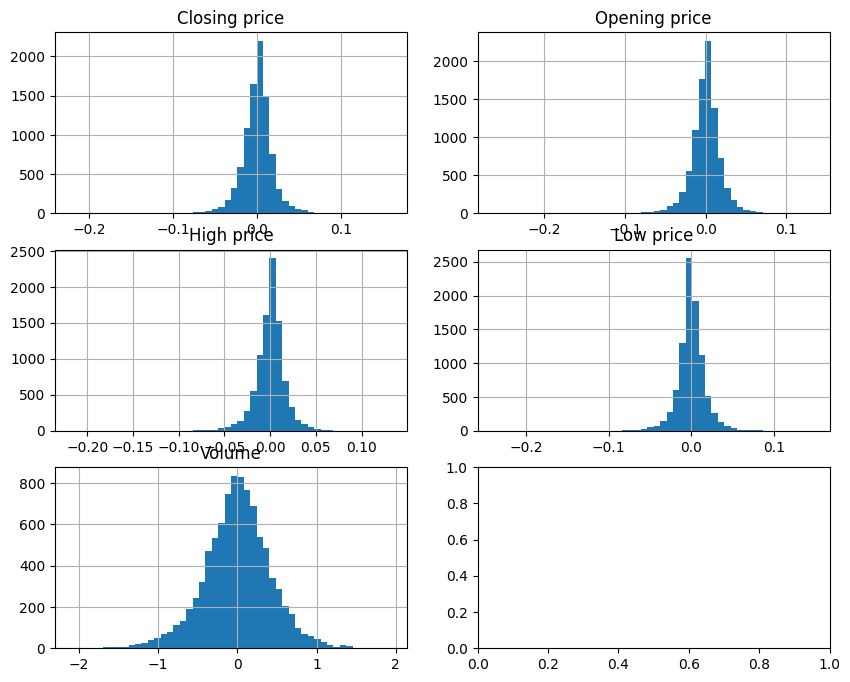

In [153]:
try:
    df_log.hist(bins=50, figsize=(10, 8))
    plt.show()
except ValueError as e:
    print(f"Warning: {e}. Ignoring this error and continuing...")

In [154]:
df_log2 = df_log.dropna()

In [96]:
adf_test(df_log2['Closing price'])

ADF Statistic: -57.826240
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Null Hypothesis. So, Time Series is Stationary




In [97]:
normality_test(df_log2['Closing price'])

Statistics=665.105, p=0.000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Data is not normally distributed(reject H0)




QQ plot

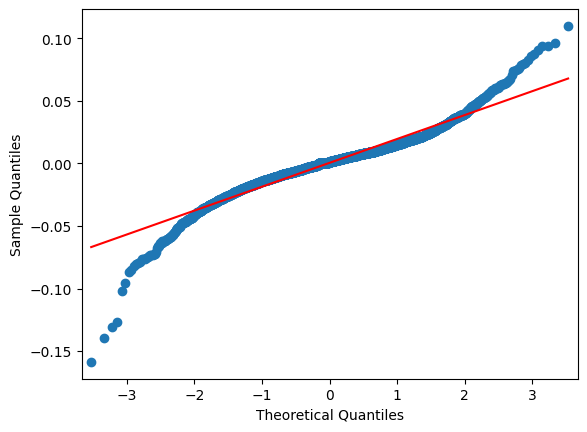

In [98]:
fig = sm.qqplot(df_log2['Closing price'], line='s')
plt.show()

## Constructing an ARIMA model with auto-fitting parameters (p,d,q)

In [99]:
!pip install pmdarima

In [100]:
from pmdarima import auto_arima

In [101]:
target=['Closing price','High price', 'Low price']

In [102]:
def arima_auto(arr):
    train_data=pd.DataFrame() # splitting into test and train data
    test_data=pd.DataFrame()
    plt.figure(figsize=(12,8))
    for i, sym in enumerate(target):
        train_data[sym], test_data[sym] = df[sym][1:int(len(df[sym])*0.8)], df[sym][int(len(df)*0.2):]
        model = auto_arima(train_data[sym], trace=True, error_action='ignore', suppress_warnings=True)
        model.fit(train_data[sym]) # fitting the model
        forecast = model.predict(n_periods=len(test_data[sym]))
        forecast = pd.DataFrame(forecast,index = test_data.index) # plot the predictions for validation set
        plt.plot(train_data, label='Train {}'.format(sym))
        plt.plot(test_data, label='Test {}'.format(sym))
        plt.plot(forecast, label='Prediction {}'.format(sym))
    plt.title('Stocks Price Prediction\n')
    plt.xlabel('Date')
    plt.ylabel('Actual Stock Price')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27483.617, Time=13.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27527.619, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27528.988, Time=0.82 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27528.968, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27525.941, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27498.462, Time=10.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27496.636, Time=12.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27480.736, Time=6.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27481.760, Time=5.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=27482.336, Time=8.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=27482.644, Time=8.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=27480.639, Time=6.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27484.012, Time=6.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=27482.617, Time=14.49 sec
 ARIMA(1,1,4)(0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26106.217, Time=9.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26173.617, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26137.905, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26137.360, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26171.995, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26125.394, Time=4.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26121.105, Time=4.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26108.217, Time=12.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26108.219, Time=18.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26139.341, Time=2.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26117.135, Time=4.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26113.859, Time=5.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=26109.314, Time=16.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=26104.630, Time=3.85 sec
 ARIMA(1,1,2)(0,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26128.630, Time=7.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26228.096, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26172.627, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26169.608, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26226.458, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26142.585, Time=4.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26136.287, Time=7.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26130.456, Time=7.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26130.434, Time=9.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26170.327, Time=1.80 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26135.181, Time=6.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26131.754, Time=4.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=26128.277, Time=14.90 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=26129.964, Time=17.19 sec
 ARIMA(3,1,4)(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


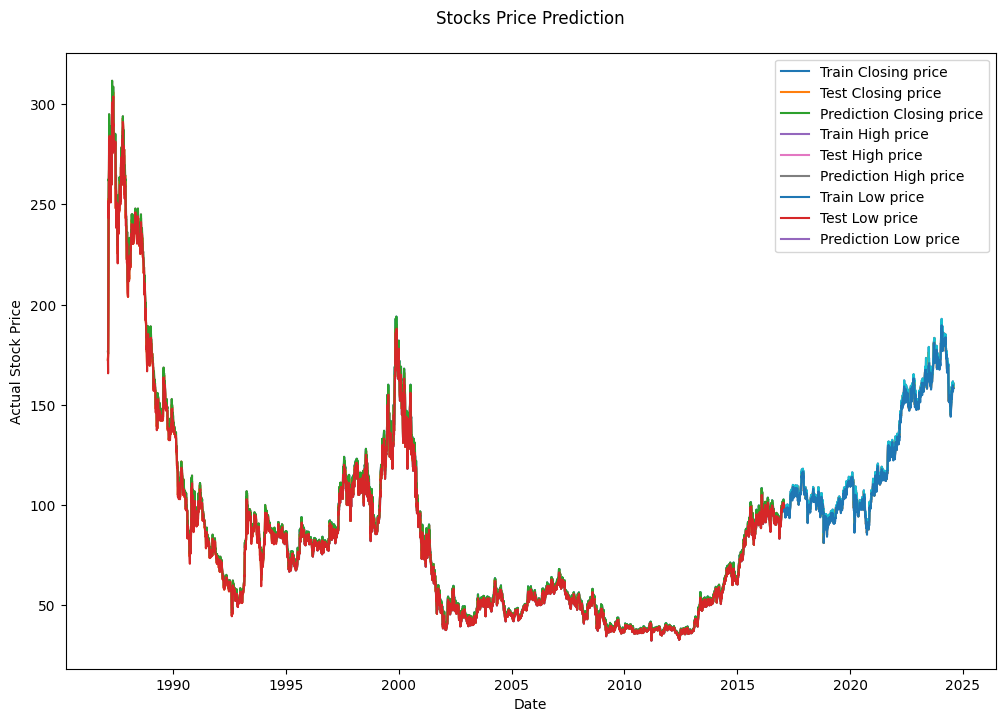

In [103]:
arima_auto(df)

Best fit ARIMA (p,d,q) parameters:

Closing price : (2,1,3)  
High price : (2,1,2)  
Low price : (3,1,3)

In [104]:
import pickle

# Save the trained ARIMA model using the pickle module
with open('arima_model_pickle.pkl', 'wb') as file:
    pickle.dump(arima_auto, file)

In [105]:
'''
# Load the saved ARIMA model using statsmodels load method
from statsmodels.tsa.arima.model import ARIMAResults
loaded_model_arima = ARIMAResults.load('arima_model.pkl')

# load the saved ARIMA model using the pickle module
with open('arima_model_pickle.pkl', 'rb') as file:
    loaded_model_arima = pickle.load(file)

predictions = loaded_model_arima.forecast(steps=30)
'''

"\n# Load the saved ARIMA model using statsmodels load method\nfrom statsmodels.tsa.arima.model import ARIMAResults\nloaded_model_arima = ARIMAResults.load('arima_model.pkl')\n\n# load the saved ARIMA model using the pickle module\nwith open('arima_model_pickle.pkl', 'rb') as file:\n    loaded_model_arima = pickle.load(file)\n\npredictions = loaded_model_arima.forecast(steps=30)\n"

# LSTM

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Data Preprocessing

In [155]:
# Selecting the 'Closing price' for prediction
data = df['Closing price'].values.reshape(-1, 1).copy()

In [108]:
# Scaling the data using MinMaxScaler to bring values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [109]:
# Define a function to create sequences of data (this is required for LSTM)
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)


In [110]:
# Define the number of time steps (how many previous days the model looks at)
time_steps = 90

In [111]:
# Create sequences
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


### Building the LSTM Model

In [112]:
# Initialize the LSTM model
model = Sequential()

# Adding the first LSTM layer with 50 units, and return sequences True since we have more LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))  # Adding dropout to avoid overfitting

# Adding the second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Output layer for predicting the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.0959e-04 - val_loss: 8.6996e-04
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.2033e-04 - val_loss: 6.5950e-04
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4.1204e-04 - val_loss: 0.0014
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 3.6947e-04 - val_loss: 0.0011
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.2128e-04 - val_loss: 5.0794e-04
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9975e-04 - val_loss: 0.0011
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.0046e-04 - val_loss: 4.1832e-04
Epoch 9/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.7071e-04 - val_loss: 3.9048e-04
Epoch 10/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4967e-04 - val_loss: 9.6325e-04
Epoch 11/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.8377

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


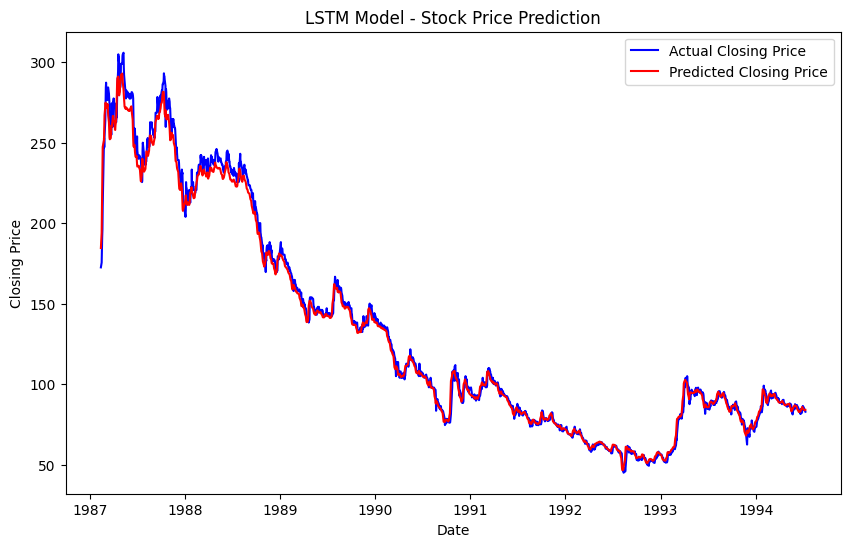

In [114]:
# Predicting on the test data
y_pred_scaled = model.predict(X_test)

# Inversely transform the scaled predictions to get the actual price values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. Plotting the Predictions vs Actual Data
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Closing Price')
plt.plot(df.index[-len(y_pred):], y_pred, color='red', label='Predicted Closing Price')
plt.title('LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [115]:
# saving LSTM model

# Method 1: Save as HDF5 format
model.save('lstm_model.h5')  # Saves the entire model (architecture, weights, optimizer)
'''
# Method 2: Save in TensorFlow's SavedModel format
model.save('lstm_model')  # Creates a directory with model info
'''

"\n# Method 2: Save in TensorFlow's SavedModel format\nmodel.save('lstm_model')  # Creates a directory with model info\n"

In [116]:
'''
# loading LSTM model
import tensorflow as tf
# Method 1: Load from HDF5 format
loaded_model = tensorflow.keras.models.load_model('lstm_model.h5')

# Method 2: Load from SavedModel format
loaded_model = tensorflow.keras.models.load_model('lstm_model')
'''

"\n# loading LSTM model\nimport tensorflow as tf\n# Method 1: Load from HDF5 format\nloaded_model = tensorflow.keras.models.load_model('lstm_model.h5')\n\n# Method 2: Load from SavedModel format\nloaded_model = tensorflow.keras.models.load_model('lstm_model')\n"

# Prophet

In [156]:
# Create the 'y' (target variable for Prophet)
# Create a 'ds' column from the existing index (which is Date)
df_pft = df.copy()
df_pft["ds"] = df_pft.index
df_pft["y"] = df_pft['Closing price']

In [157]:
# Drop any NaN values (if necessary)
df_pft.dropna(subset=['y'], inplace=True)

In [158]:
from prophet import Prophet

# Initialize the Prophet model
model_fbp = Prophet()

# Fit the Prophet model to the data
model_fbp.fit(df_pft[['ds', 'y']])

# Make predictions
future = model_fbp.make_future_dataframe(periods=30)  # Forecast 30 days into the future
forecast = model_fbp.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmk4qe3_w/mjkma72f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmk4qe3_w/_2n_qrzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33111', 'data', 'file=/tmp/tmpmk4qe3_w/mjkma72f.json', 'init=/tmp/tmpmk4qe3_w/_2n_qrzu.json', 'output', 'file=/tmp/tmpmk4qe3_w/prophet_model8ctv5wjf/prophet_model-20241011085944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:59:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


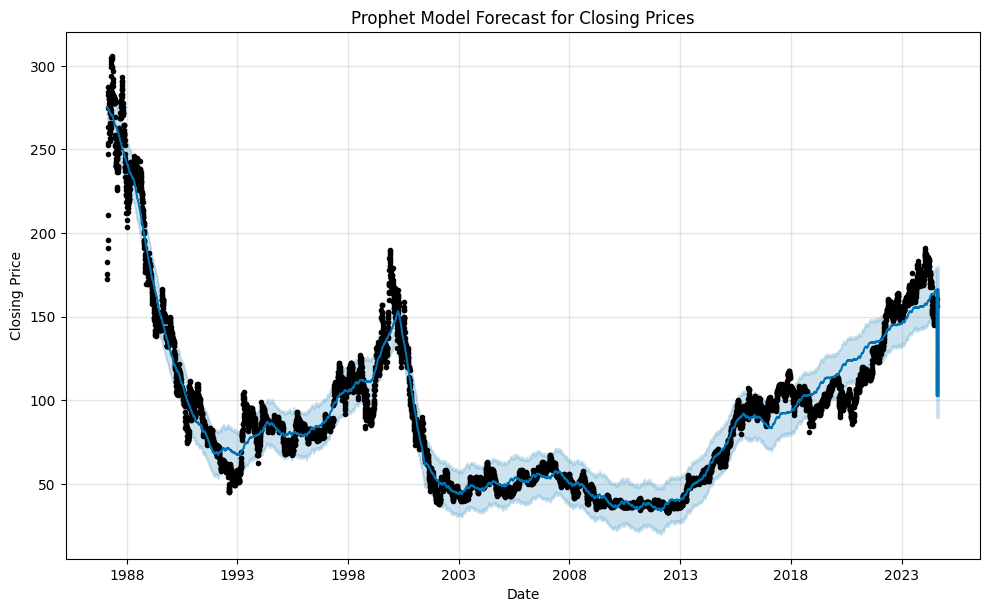

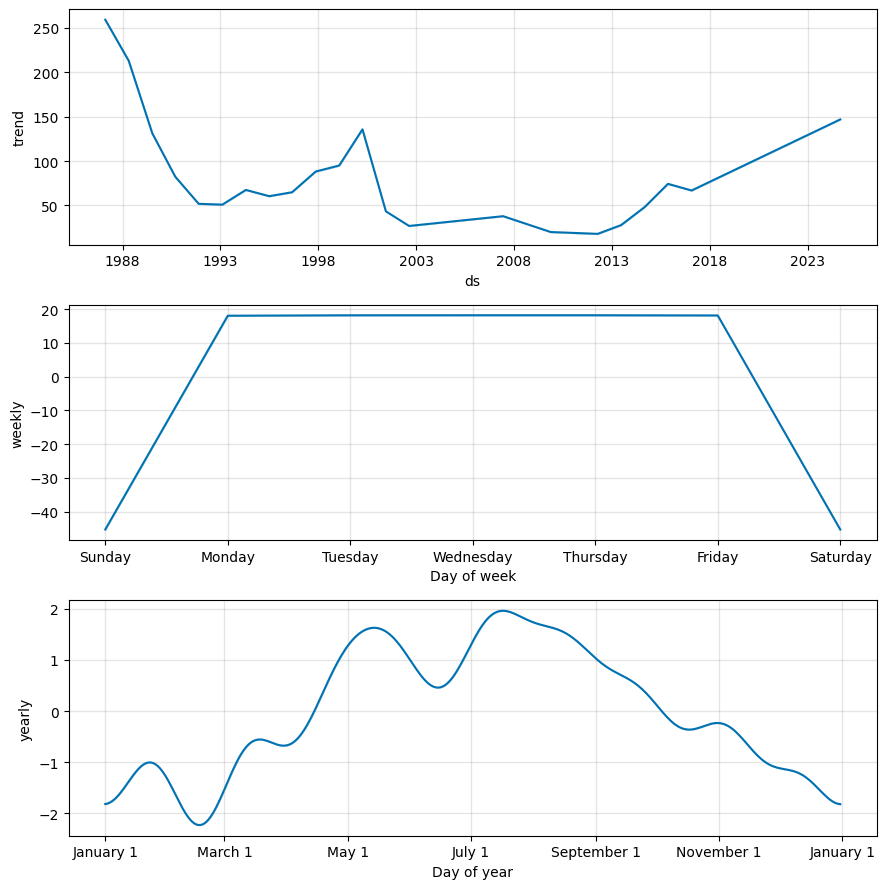

In [159]:
# Plot the forecasted data
fig = model_fbp.plot(forecast)
plt.title('Prophet Model Forecast for Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Plot forecast components (trend, seasonality, etc.)
fig2 = model_fbp.plot_components(forecast)
plt.show()


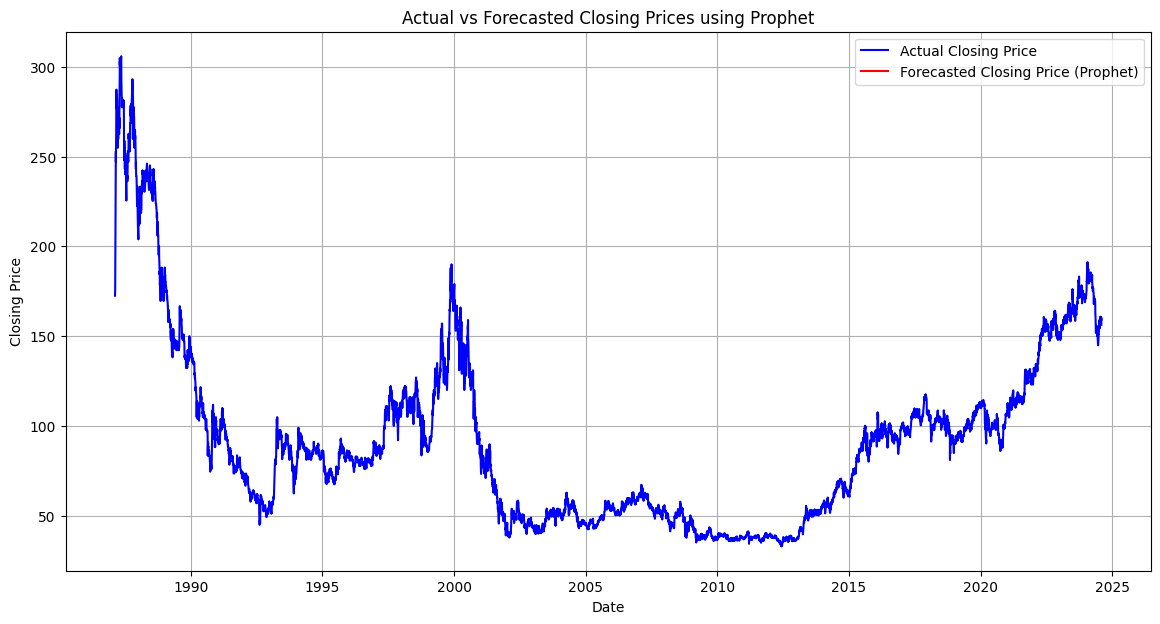

In [160]:
# Adding the forecasted values to the original dataframe for comparison
df_pft['Forecast_Prophet'] = forecast['yhat'][:len(df_pft)]

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(df_pft['ds'], df_pft['y'], label='Actual Closing Price', color='blue')
plt.plot(df_pft['ds'], df_pft['Forecast_Prophet'], label='Forecasted Closing Price (Prophet)', color='red')
plt.title('Actual vs Forecasted Closing Prices using Prophet')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


In [161]:
import pickle

# Save the trained model to a file
with open('prophet_model.pkl', 'wb') as file:
    pickle.dump(model_fbp, file)

In [123]:
"""
# Load the trained model from a file
with open('prophet_model.pkl', 'rb') as file:
    loaded_model_fbp = pickle.load(file)

# Now you can use the loaded model to make predictions
future = loaded_model_fbp.make_future_dataframe(periods=30)
forecast = loaded_model_fbp.predict(future)
"""

"\n# Load the trained model from a file\nwith open('prophet_model.pkl', 'rb') as file:\n    loaded_model_fbp = pickle.load(file)\n\n# Now you can use the loaded model to make predictions\nfuture = loaded_model_fbp.make_future_dataframe(periods=30)\nforecast = loaded_model_fbp.predict(future)\n"

# Test performance

In [162]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [163]:
split_date = pd.to_datetime('2022-12-27')
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

### ARIMA

In [165]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

train = df_train['Closing price']
test = df_test['Closing price']

# Fit the ARIMA model (replace order=(p, d, q) with your ARIMA parameters)
model_arima = ARIMA(train, order=(2, 1, 3))  # Specify your ARIMA (p, d, q) order
model_arima_fit = model_arima.fit()

# Make predictions on the test set
start = len(train)  # Start predicting from the point where training data ends
end = start + len(test) - 1  # End prediction at the end of the test data
predictions = model_arima_fit.predict(start=start, end=end, dynamic=False)  # ARIMA predictions


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [166]:
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 10.051380913143657
Mean Squared Error (MSE): 145.63218534368045
Root Mean Squared Error (RMSE): 12.067816096696223
R-squared (R²): -0.3421485642420923


### LSTM

In [167]:
# Selecting the 'Closing price' for prediction
data = df_train['Closing price'].values.reshape(-1, 1).copy()
# Scaling the data using MinMaxScaler to bring values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
# Define a function to create sequences of data (this is required for LSTM)
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)
time_steps = 90
# Create sequences
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train = X[:]
y_train = y[:]

# Check the shapes of the reshaped arrays
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')


Shape of X_train: (8700, 90, 1)
Shape of y_train: (8700,)


In [168]:
# Selecting the 'Closing price' for prediction
data = df_test['Closing price'].values.reshape(-1, 1).copy()
# Scaling the data using MinMaxScaler to bring values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
# Define a function to create sequences of data (this is required for LSTM)
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)
time_steps = 90
# Create sequences
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_test = X[:]
y_test = y[:]

# Check the shapes of the reshaped arrays
print(f'Shape of X_train: {X_test.shape}')
print(f'Shape of y_train: {y_test.shape}')

Shape of X_train: (302, 90, 1)
Shape of y_train: (302,)


In [169]:
# loading LSTM model
import tensorflow as tf
loaded_model_lstm = tf.keras.models.load_model('lstm_model.h5')
loaded_model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [170]:
y_pred = loaded_model_lstm.predict(X_test)  # Replace with actual LSTM prediction

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [171]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared (R²): {r2}')

MAE: 0.03596926739633673
MSE: 0.00223359777281582
RMSE: 0.047260953998156024
R-squared (R²): 0.9508310190171162


### PROPHET

In [172]:
# Prepare your test dataset

df_test = pd.DataFrame({
    'ds': pd.to_datetime(df_test.index),
    'y': df_test['Closing price']
})

In [173]:
# Load the trained model from a file
with open('prophet_model.pkl', 'rb') as file:
    loaded_model_fbp = pickle.load(file)

# Now you can use the loaded model to make predictions
future = loaded_model_fbp.make_future_dataframe(periods=30)
forecast = loaded_model_fbp.predict(future)

In [174]:
# Get the predictions for the test dates
predictions = forecast[forecast['ds'].isin(df_test['ds'])]['yhat'].values

In [175]:
# Evaluate the model's performance
mae = mean_absolute_error(df_test['y'], predictions)
mse = mean_squared_error(df_test['y'], predictions)
rmse = mean_squared_error(df_test['y'], predictions, squared=False)  # RMSE
r2 = r2_score(df_test['y'], predictions)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


Mean Absolute Error (MAE): 13.643669138713012
Mean Squared Error (MSE): 268.3066545856454
Root Mean Squared Error (RMSE): 16.38006882115107
R-squared (R²): -1.4727184473603683


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Consideration of Improvements and Model Retraining

Overview:

* The performance metrics indicate that the LSTM model outperforms both the ARIMA and Prophet models, particularly in terms of R² and error metrics. The ARIMA and Prophet models have negative R² values, suggesting poor fit compared to a simple mean model.

**Areas for Improvement:**


Data Quality:
* Ensure that the data is clean and free of outliers, missing values, and
non-finite values.
Feature Engineering: Experiment with additional features or transformations that may enhance model performance (e.g., adding lag features, moving averages, or external regressors).

* Hyperparameter Tuning: Optimize hyperparameters for the LSTM model using techniques like grid search or randomized search.
* Regularization: Introduce regularization techniques in LSTM to avoid overfitting.
* Cross-Validation: Implement cross-validation techniques to assess model robustness across different subsets of the data.


Summarizing Results and Creating Presentation Materials

Overview:

Model Comparison:

ARIMA:
* MAE: 10.05
* MSE: 145.63
* RMSE: 12.07
* R²: -0.34

The ARIMA model demonstrates relatively high error metrics and a negative R² value, indicating that it does not fit the data better than a simple mean model. This suggests that the ARIMA approach may not capture the underlying trends or seasonality effectively for this dataset.

LSTM:
* MAE: 0.036
* MSE: 0.0022
* RMSE: 0.047
* R²: 0.951

The LSTM model significantly outperforms the other models, as evidenced by its low error metrics and high R² value. This indicates that the LSTM captures the complexities of the time series data, providing accurate predictions with minimal error.

Prophet:
* MAE: 13.64
* MSE: 268.31
* RMSE: 16.38
* R²: -1.47

Similar to ARIMA, the Prophet model exhibits high error metrics and a negative R² value, suggesting inadequate performance. While Prophet is designed for handling seasonality and trends, its results in this case indicate that it may not be suitable for the specific characteristics of the stock price dataset.


In summary, while the LSTM model currently provides the most accurate predictions for the stock price dataset, there is room for improvement across all models. By enhancing data quality, employing robust feature engineering, optimizing model parameters, and experimenting with ensemble methods, we can work towards developing a more accurate and reliable prediction model. These efforts not only enhance performance but also contribute to a deeper understanding of the underlying data dynamics.
